In [252]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [253]:
class DSO:
	def __init__(self, totalHours, marginalCost, unitSalePrice, maxPriceReference):
		self.totalHours = totalHours
		self.numberOfAggregators = 0
		self.marginalCost = marginalCost
		self.unitSalePrice = unitSalePrice
		self.maxPriceReference = maxPriceReference
		self.aggregators = []
		self.maxUtility = 0
		self.m = 0

	def addAggregator(self, aggregator):
		self.aggregators.append(aggregator)
		self.numberOfAggregators = self.numberOfAggregators + 1

	def getAggregators(self):
		return self.aggregators

	def Sfunction(self, aggregator, tIndex):
		return aggregator.maximumDemand[tIndex] * aggregator.maxPriceReference * (1 - np.exp(-aggregator.preferenceSatisfaction[tIndex] * (aggregator.bestLoadResponse[tIndex] / aggregator.nominalDemand[tIndex])))
	
	def CostFunction(self, aggregator, tIndex):
		return self.marginalCost[tIndex]
	
	def getLeftLimit(self):
		leftLimit = [0 for i in range(self.totalHours)]
		for i in range(self.totalHours):
			mx = 0
			for j in range(self.numberOfAggregators):
				agg = self.aggregators[j]
				mx = max(mx, agg.preferenceSatisfaction[i] * agg.maxPriceReference * np.exp(-agg.preferenceSatisfaction[i] * (agg.maximumDemand[i] / agg.nominalDemand[i])))
			leftLimit[i] = mx
		return leftLimit
	
	def getRightLimit(self):
		rightLimit = [0 for i in range(self.totalHours)]
		for i in range(self.totalHours):
			mx = 0
			for j in range(self.numberOfAggregators):
				agg = self.aggregators[j]
				mx = max(mx, agg.preferenceSatisfaction[i] * agg.maxPriceReference * np.exp(-agg.preferenceSatisfaction[i] * (agg.minimumDemand[i] / agg.nominalDemand[i])))
			rightLimit[i] = mx
		return rightLimit
	
	def generateUnitSalePrice(self):
		minPrice = self.marginalCost
		leftLimit = self.getLeftLimit()
		minPrice = np.minimum(minPrice, leftLimit)

		maxPrice = self.maxPriceReference
		rightLimit = self.getRightLimit()
		maxPrice = np.maximum(maxPrice, rightLimit)

		for i in range(self.totalHours):
			self.unitSalePrice[i] = random.uniform(minPrice[i], maxPrice[i])

	def generateM(self):
		m = 0
		mx = 0
		for i in range(self.totalHours):
			sum = 0
			for j in range(self.numberOfAggregators):
				agg = self.aggregators[j]
				sum = sum + agg.bestLoadResponse[i]
			mx = max(mx, sum)
		m = random.uniform(mx, mx*10)
		self.m = m

	def utilityFunction(self, m, theta, omega):
		# self.generateUnitSalePrice()
		self.generateM()
		print('m value:', self.m)

		# store value of INT_MIN in mx
		mx = -1000000000000
		for j in range(self.totalHours):
			sum = 0
			for i in range(self.numberOfAggregators):
				agg = self.aggregators[i]
				sum = sum + self.unitSalePrice[j] * agg.bestLoadResponse[j] - self.CostFunction(agg, j) * agg.bestLoadResponse[j] + omega * self.Sfunction(agg, j)
			sum = sum - theta*m
			mx = max(mx, sum)
		return mx

	def getPAR(self):
		# sum of all bestResponses for each hour for each aggregator
		sum = 0
		for i in range(self.totalHours):
			for j in range(self.numberOfAggregators):
				sum = sum + self.aggregators[j].bestLoadResponse[i]
		return (self.m * self.totalHours) / (sum)

class Aggregator:
	def __init__(self, totalHours, nominalDemand, minimumDemand, maximumDemand, maxPriceReference, preferenceSatisfaction):
		self.totalHours = totalHours
		self.nominalDemand = nominalDemand
		self.minimumDemand = minimumDemand
		self.maximumDemand = maximumDemand
		self.maxPriceReference = maxPriceReference
		self.preferenceSatisfaction = preferenceSatisfaction
		self.currentUtility = 0
		self.bestLoadResponse = []

	def utilityFunction(self, DSO):
		sum = 0
		for i in range(DSO.totalHours):
			sum = sum + DSO.Sfunction(self, i) - (DSO.unitSalePrice[i] * self.bestLoadResponse[i])
		return sum

	def optimalDR(self, DSO):
		self.bestLoadResponse = []
		for j in range(DSO.totalHours):
			self.bestLoadResponse.append((self.nominalDemand[j] / self.preferenceSatisfaction[j]) * (np.log((self.preferenceSatisfaction[j] * self.maxPriceReference) / DSO.unitSalePrice[j])))


In [254]:
datasetPath = '../dataset/'

In [255]:
numOfLA = 3
numOfHours = 50

In [256]:
nominalDemands = []
for i in range (0, 3):
	letter = chr(ord('A') + i)
	fileName = 'Home' + letter + '_hourly.csv'
	df = pd.read_csv(datasetPath + fileName)
	df = df[0:numOfHours]
	# Power is in kW
	nominalDemands.append(df['Power'].tolist())

In [257]:
LAs = []
# maxPriceReference = 30
maxPriceReference = 10000
for i in range(numOfLA):
	nominalDemand = nominalDemands[i]
	# find max of nominalDemand
	maxNominalDemand = max(nominalDemand)
	minimumDemand = np.random.uniform(0.0001, nominalDemand, numOfHours)
	maximumDemand = np.random.uniform(nominalDemand, maxNominalDemand+1, numOfHours)
	preferenceSatisfaction = np.random.uniform(0.1, 15, numOfHours)
	LAs.append(Aggregator(numOfHours, nominalDemand, minimumDemand, maximumDemand, maxPriceReference, preferenceSatisfaction))


In [258]:
# # print all the values for each LA
# for i in range(numOfLA):
# 	print("LA", i)
# 	print("nominal demand: ", LAs[i].nominalDemand)
# 	print("minimum demand: ", LAs[i].minimumDemand)
# 	print("maximum demand: ", LAs[i].maximumDemand)
# 	print("max price reference: ", LAs[i].maxPriceReference)
# 	print("preference satisfaction: ", LAs[i].preferenceSatisfaction)

In [259]:
marginalCost = np.random.randint(1, 7, numOfHours) # cent/kW
unitSalePrice = np.random.randint(1, 7, numOfHours) # cent/kWh
dso = DSO(numOfHours, marginalCost, unitSalePrice, maxPriceReference)

In [260]:
# append all the LAs to the DSO
for i in range(numOfLA):
	dso.addAggregator(LAs[i])

In [261]:
# # print all the values for the DSO
# print("DSO")
# print("marginal cost: ", dso.marginalCost)
# print("unit sale price: ", dso.unitSalePrice)


In [262]:
dso.generateUnitSalePrice()

In [263]:
# print Unit Sale Price
print("Unit Sale Price: ", dso.unitSalePrice)

Unit Sale Price:  [44688  3392 25912  6070  9119  3057 33081  3926  7443  6543  9195 26900
  5276  3621  3823  2544 24524 14585   190  9332  9717  7514  8502  4775
  1272 14062  4870 54092  4156  1185  4774 16629 43106  4834  4107 96164
 10595  4730  2321  1472  2003  4725 17184  1602  3577 46300  6306  6165
  6620  2272]


In [264]:
# DSO gives the price for each hour & each LA calculates the optimal DR
for i in range(numOfLA):
	# la = LAs[i]
	la = dso.aggregators[i]
	la.optimalDR(dso)

In [265]:
# print best load response for each LA
for i in range(numOfLA): # kWh
	print("LA", i)
	print("best load response: ", dso.aggregators[i].bestLoadResponse)

LA 0
best load response:  [0.006002009510236788, 0.14811128410015365, 0.03909745295520904, 0.12887806246843841, 0.06072098004740414, 0.3054473094640179, 0.05523144908492701, 0.23600221657359555, 0.1903475634641289, 0.20610215152205694, 0.21003949076390516, 0.08717258963089076, 0.08204630581617631, 0.09553449848921436, 0.5984537186433322, 0.7776416636765968, 0.10277744874856094, 0.1257177702091623, 0.8629017930516741, 0.13512205341343217, 0.10631648647068294, 0.17028239814559673, 0.084361689425629, 0.08498579195046972, 0.20675348877683813, 0.06761588430655088, 0.09331742584237578, 0.01868098641635011, 0.0900633073022614, 0.14669389260227947, 0.13002556957613373, 0.08731868469386508, 0.050687784470233595, 0.13952940183197027, -3.3935871804710387, 0.007178527869291803, 0.10081355735093216, 0.36850276128805287, 0.29187111132293975, 0.25574125625504174, 0.6221822414478049, 0.2462057848120483, 0.08433686048540404, 0.22326489295342222, 0.12419974205614433, 0.03456257965529263, 0.2299933963136

In [266]:
# # check for negative values in each LA best load response
# for i in range(numOfLA):
# 	la = dso.aggregators[i]
# 	for j in range(numOfHours):
# 		if la.bestLoadResponse[j] < 0:
# 			print("LA", i, "best load response for hour", j, "is negative")

In [267]:
# DSO takes back the load response from each aggregator
m = np.random.randint(1, 100)
omega = 5
theta = 0.01

dso.maxUtility = dso.utilityFunction(m, theta, omega)
dso.maxUtility

m value: 69.13928409743338


863362.499947474

In [274]:
# DSO takes back the load response from each aggregator
m = np.random.randint(1, 100)
omega = 6
theta = 0.02

dso.maxUtility = dso.utilityFunction(m, theta, omega)
dso.maxUtility

m value: 59.795305573575284


1033970.7028771566

In [278]:
# DSO takes back the load response from each aggregator
m = np.random.randint(1, 100)
omega = 2
theta = 0.1

dso.maxUtility = dso.utilityFunction(m, theta, omega)
dso.maxUtility

m value: 101.23938546876184


351530.251158426

In [268]:
# print utility for each house
for i in range(numOfLA):
	print("LA", i)
	ut = LAs[i].utilityFunction(dso)
	print("utility: ", ut)

LA 0
utility:  380507.40498616366
LA 1
utility:  2399637.410134177
LA 2
utility:  1397118.3777158393


In [269]:
dso.getPAR()

39.876714886600354

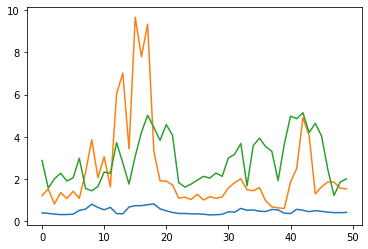

In [270]:
# plot nominal demand of each LA
for i in range(numOfLA):
	plt.plot(LAs[i].nominalDemand)
plt.show()

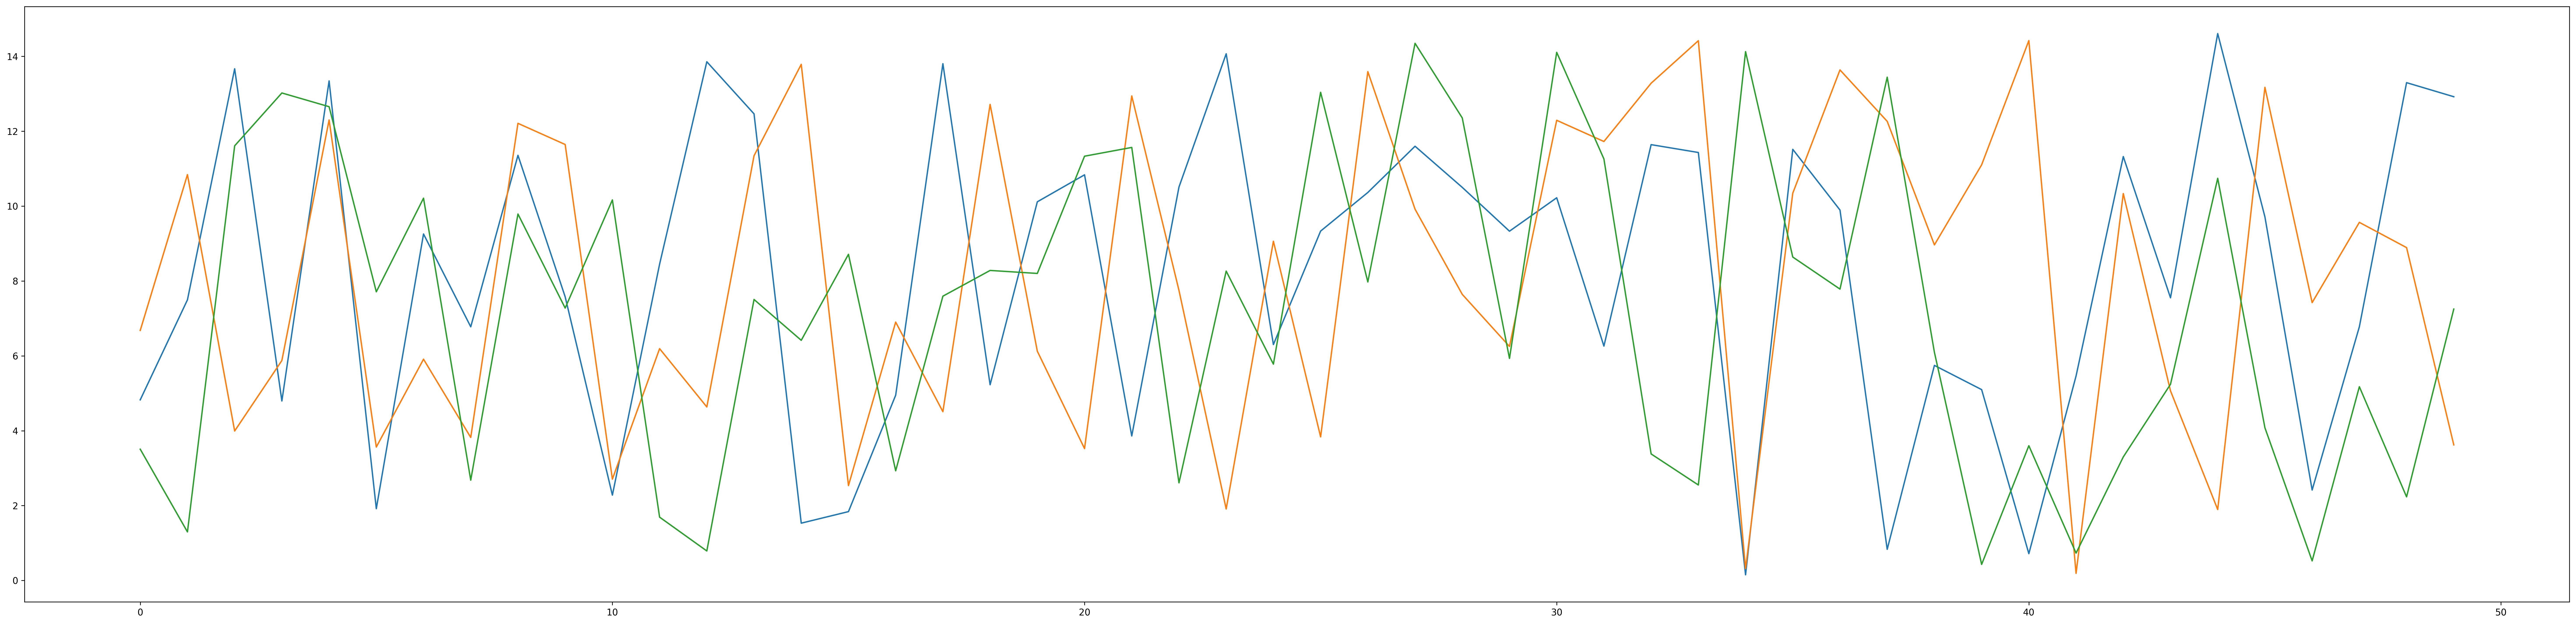

In [271]:
# plot user pref of each LA
plt.figure(figsize=(50, 12), dpi=300)
for i in range(numOfLA):
	plt.plot(LAs[i].preferenceSatisfaction)
plt.show()

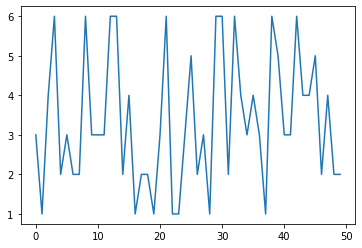

In [272]:
# plot marginal cost
plt.plot(dso.marginalCost)
plt.show()

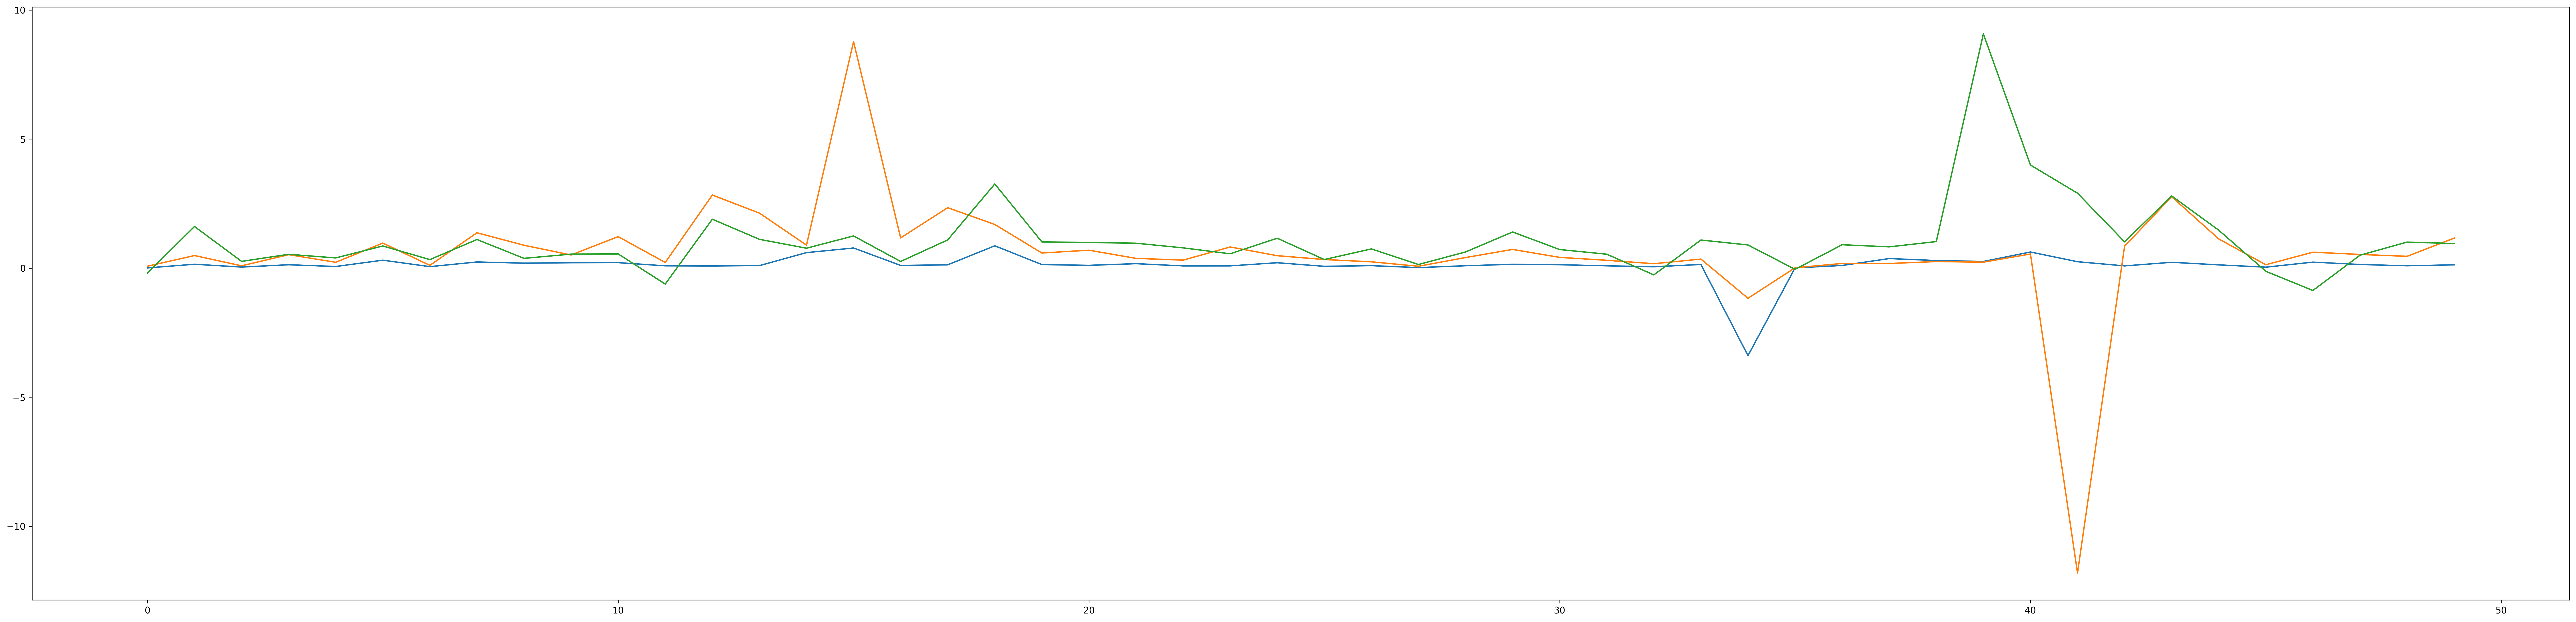

In [273]:
# plot bestLoadResponse of each LA
plt.figure(figsize=(50, 12), dpi=300)
for i in range(numOfLA):
	plt.plot(LAs[i].bestLoadResponse)
plt.show()